### This is the code for creating pair dataset with images and ocr for multimodal model.

In [ ]:
import os 
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import shutil

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random

from tqdm import tqdm

from torchvision.transforms import RandomRotation, ColorJitter, RandomHorizontalFlip, RandomCrop
from torchvision.transforms import RandomAffine

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def create_pairs_with_ocr(split_dir, output_dir, results_file, ocr_results_file, max_pairs_per_match=400):
    os.makedirs(output_dir, exist_ok=True)
    matches = os.listdir(split_dir)

    # load match results and ocr
    results_df = pd.read_csv(results_file)
    results_map = results_df.set_index('Match')['Result'].to_dict()

    ocr_df = pd.read_csv(ocr_results_file)
    ocr_df['match_id'] = ocr_df['image'].apply(lambda x: x.split('/')[0])  
    ocr_df['frame_name'] = ocr_df['image'].apply(lambda x: x.split('/')[1]) 
    ocr_map = ocr_df.set_index(['match_id', 'frame_name']).to_dict(orient='index')
    
    all_pairs = []

    for match_id in tqdm(matches, desc="Processing Matches", unit="match"):
        match_folder = os.path.join(split_dir, match_id)
        if not os.path.isdir(match_folder):
            continue

        match_id_int = int(match_id)
        if match_id_int not in results_map:
            print(f"Match {match_id} skipped (no result found).")
            continue

        match_label = results_map[match_id_int]
        frames = sorted([f for f in os.listdir(match_folder) if f.endswith('.jpg')])

        if len(frames) < 6:
            print(f"Match {match_id} skipped (not enough frames).")
            continue

        num_frames = len(frames)
        thirds = num_frames // 3
        early_frames = frames[:thirds]
        mid_frames = frames[thirds:2*thirds]
        late_frames = frames[2*thirds:]

        pairs = []
        # set to avoid duplicate images
        used_images = set() 

        with tqdm(total=max_pairs_per_match, desc=f"Creating Pairs for Match {match_id}", unit="pair", leave=False) as pbar:
            while len(pairs) < max_pairs_per_match:
                try:
                    # select frames for each stage
                    early = random.choice([f for f in early_frames if f not in used_images])
                    mid = random.choice([f for f in mid_frames if f not in used_images])
                    late = random.choice([f for f in late_frames if f not in used_images])

                    # add frames to used set
                    used_images.update([early, mid, late])

                    # save pairs
                    pair = (early, mid, late)
                    pairs.append(pair)

                    match_output_dir = os.path.join(output_dir, match_id)
                    os.makedirs(match_output_dir, exist_ok=True)

                    pair_data = []
                    for stage, frame in zip(["early", "mid", "late"], pair):
                        src = os.path.join(match_folder, frame)
                        dst = os.path.join(match_output_dir, f"{match_id}_pair_{len(pairs)}_{stage}.jpg")
                        shutil.copy(src, dst)

                        # process augmented frames to extract original frame name
                        if '_aug' in frame:
                            original_frame = frame.split('_aug')[0]
                            original_frame = original_frame + '.jpg'
                        else:
                            original_frame = frame

                        ocr_result = ocr_map.get((str(match_id), original_frame))
                        if ocr_result is None:
                            print(f"OCR result missing for {original_frame} in match {match_id}")

                        pair_data.append({
                            'match_id': match_id,
                            'pair_id': len(pairs),
                            'stage': stage,
                            'file': dst,
                            'label': match_label,
                            **(ocr_result if ocr_result else {}) 
                        })

                    all_pairs.extend(pair_data)

                    pbar.update(1) 

                    # stop if no more frames available
                    if not any(f not in used_images for f in early_frames + mid_frames + late_frames):
                        break

                except IndexError:
                    break
    
    # save
    pairs_df = pd.DataFrame(all_pairs)
    pairs_df.to_csv(os.path.join(output_dir, 'pairs.csv'), index=False)
    print(f"Pairs created and saved to {os.path.join(output_dir, 'pairs.csv')}")

In [ ]:
# base directories
frames_dir = './data/masked_frames'
results_file = './data/frames/results.csv'
split_output_dir = './data/masked_frame_split_by_match'

In [14]:
ocr_pair_output_dir_train = './data/maksed_frame_split_by_match_pair_ocr/train'
ocr_pair_output_dir_val = './data/maksed_frame_split_by_match_pair_ocr/val'
ocr_pair_output_dir_test = './data/maksed_frame_split_by_match_pair_ocr/test'

In [15]:
create_pairs_with_ocr(os.path.join(split_output_dir, 'train'), ocr_pair_output_dir_train, results_file, './cleaned_ocr_results.csv')

Processing Matches:   0%|          | 0/63 [00:00<?, ?match/s]

Processing Matches: 100%|██████████| 63/63 [00:26<00:00,  2.36match/s]


Pairs created and saved to ./data/maksed_frame_split_by_match_pair_ocr/train/pairs.csv


In [16]:
create_pairs_with_ocr(os.path.join(split_output_dir, 'val'), ocr_pair_output_dir_val, results_file, './cleaned_ocr_results.csv')

Processing Matches:  14%|█▍        | 3/21 [00:00<00:00, 24.08match/s]

Processing Matches: 100%|██████████| 21/21 [00:00<00:00, 22.09match/s]


Pairs created and saved to ./data/maksed_frame_split_by_match_pair_ocr/val/pairs.csv


In [17]:
create_pairs_with_ocr(os.path.join(split_output_dir, 'test'), ocr_pair_output_dir_test, results_file, './cleaned_ocr_results.csv')

Processing Matches:  14%|█▎        | 3/22 [00:00<00:00, 25.14match/s]

Processing Matches: 100%|██████████| 22/22 [00:00<00:00, 23.14match/s]

Pairs created and saved to ./data/maksed_frame_split_by_match_pair_ocr/test/pairs.csv


In [ ]:
# Check the data if it is created correctly

In [ ]:
class PairDataset(Dataset):
    def __init__(self, pairs_csv, transform=None):
        self.data = pd.read_csv(pairs_csv)
        self.transform = transform

    def __len__(self):
        return len(self.data) // 3

    def __getitem__(self, idx):
        start_idx = idx * 3
        pair_data = self.data.iloc[start_idx:start_idx + 3]

        images = []
        ocr_data = []  
        label = pair_data.iloc[0]['label'] 
        for _, row in pair_data.iterrows():
            image = Image.open(row['file']).convert("RGB")
            if self.transform:
                image = self.transform(image)
            images.append(image)

            # add ocr info
            ocr_info = row[['region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6']].values
            ocr_info_numeric = []
            for value in ocr_info:
                try:
                    if isinstance(value, str):
                        # replace incorrect characters
                        value = value.replace('I', '1').replace('"', '')
                        # if k exists, delete
                        if 'K' in value:
                            value = float(value.replace('K', ''))

                    ocr_info_numeric.append(float(value)) 
                except ValueError:
                    # if value is not a number, add 0
                    ocr_info_numeric.append(0.0) 

            ocr_data.append(ocr_info_numeric)

        # combine images
        combined = torch.stack(images)  
        # OCR 정보를 텐서로 변환
        ocr_tensor = torch.tensor(ocr_data, dtype=torch.float32)  
        return combined, ocr_tensor, label

In [ ]:
ocr_pair_output_dir_train = './data/maksed_frame_split_by_match_pair_ocr/train'
ocr_pair_output_dir_val = './data/maksed_frame_split_by_match_pair_ocr/val'
ocr_pair_output_dir_test = './data/maksed_frame_split_by_match_pair_ocr/test'


transform = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size=8


ocr_pairs_csv_train = os.path.join(ocr_pair_output_dir_train, 'pairs.csv')
ocr_train_dataset = PairDataset(ocr_pairs_csv_train, transform=transform)
ocr_train_loader = DataLoader(ocr_train_dataset, batch_size=batch_size, shuffle=True)

ocr_pairs_csv_val = os.path.join(ocr_pair_output_dir_val, 'pairs.csv')
ocr_val_dataset = PairDataset(ocr_pairs_csv_val, transform=transform)
ocr_val_loader = DataLoader(ocr_val_dataset, batch_size=batch_size, shuffle=False)

ocr_pairs_csv_test = os.path.join(ocr_pair_output_dir_test, 'pairs.csv')
ocr_test_dataset = PairDataset(ocr_pairs_csv_test, transform=transform)
ocr_test_loader = DataLoader(ocr_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# check data shape
for images, ocr_data, labels in ocr_train_loader:
    # (batch_size, 3, C, H, W) 
    print(images.shape)   
    # (batch_size, 3, 6) 
    print(ocr_data.shape) 
    # (batch_size,)
    print(labels.shape)   
    break

torch.Size([8, 3, 3, 600, 600])
torch.Size([8, 3, 6])
torch.Size([8])


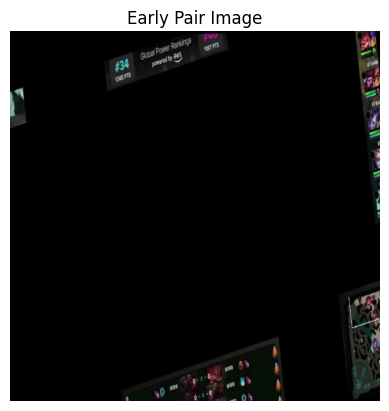

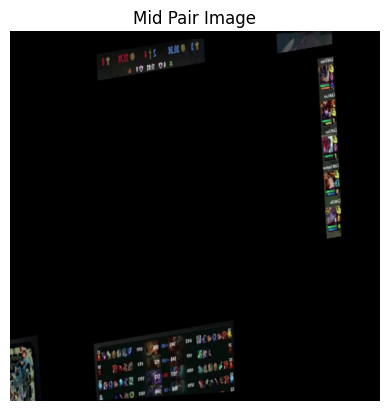

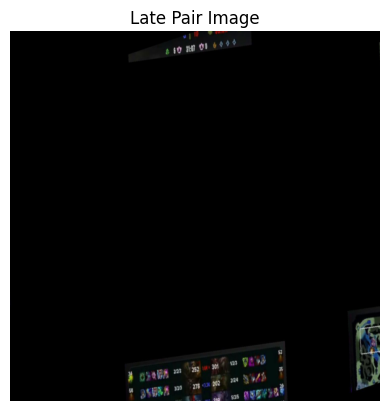

OCR Data (First Sample):
Early OCR Data: [0.  2.5 0.  0.  2.5 0. ]
Mid OCR Data: [ 3.  30.3  2.   4.  27.7  0. ]
Late OCR Data: [ 9.  60.7  8.  10.  55.8  3. ]

Label (First Sample):
0


In [ ]:
# visualise and print data
for images, ocr_data, labels in ocr_train_loader:
    # visualise images
    pair_images = images[0]  
    stages = ["Early", "Mid", "Late"]
    for i, image in enumerate(pair_images):
        # recover 
        img = image.permute(1, 2, 0).numpy()  
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"{stages[i]} Pair Image")
        plt.axis("off")
        plt.show()

    # print ocr data
    print("OCR Data (First Sample):")
    for i, ocr_stage in enumerate(ocr_data[0]):  
        print(f"{stages[i]} OCR Data: {ocr_stage.numpy()}")

    # print label
    print("\nLabel (First Sample):")
    print(labels[0].item()) 

    break  